In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
# pltのlabelで日本語を使うために必要なモジュールをインポート
import japanize_matplotlib
from matplotlib import rc
from matplotlib.font_manager import FontProperties
from scipy.stats import norm
from scipy.linalg import expm
from math import factorial
import tqdm

In [112]:
import numpy as np

def var(h):
    # 固有値の定義
    lambda_1 = -1/2 * 1j * (np.sqrt(3) - 1j)
    lambda_2 = 1/2 * 1j * (np.sqrt(3) + 1j)

    # h と theta_1_squared の値
    # 任意の値を代入できます。ここでは 1 を使用。
    # 任意の値を代入できます。ここでは 1 を使用。
    theta1_matrix = np.array([[1, 0], [0, 0]], dtype=np.complex128)

    # 行列 S の定義
    SS = np.array([[-1/2 * 1j * (np.sqrt(3) - 1j), 1/2 * 1j * (np.sqrt(3) + 1j)],
                [1, 1]], dtype=np.complex128)  # 変更

    # 行列 S の逆行列の定義
    SS_inv = np.array([[1j / np.sqrt(3), 1/6 * (3 + 1j * np.sqrt(3))],
                    [-1j / np.sqrt(3), 1/6 * (3 - 1j * np.sqrt(3))]], dtype=np.complex128)  # 変更

    # λi + λj のすべての組み合わせを計算
    lambdas = [lambda_1, lambda_2]
    exp_term = np.zeros((2, 2), dtype=np.complex128)  # 変更

    # 関数の計算
    for i in range(2):
        for j in range(2):
            alpha = lambdas[i] + lambdas[j]
            exp_term[i, j] = (np.exp(alpha * h, dtype=np.complex128) - 1) / alpha  # 変更

    # 行列積の計算
    result =  np.einsum('hi,ij,ip,pq,qj,jk->hk',SS,exp_term,SS_inv,theta1_matrix,SS,SS_inv)

    return np.real(result)
def exp_Ah(h):
    # 固有値の定義
    lambda_1 = -1/2 * 1j * (np.sqrt(3) - 1j)
    lambda_2 = 1/2 * 1j * (np.sqrt(3) + 1j)

    # h と theta_1_squared の値
    # 任意の値を代入できます。ここでは 1 を使用。
    #  # 任意の値を代入できます。ここでは 1 を使用。

    # 行列 S の定義
    SS = np.array([[-1/2 * 1j * (np.sqrt(3) - 1j), 1/2 * 1j * (np.sqrt(3) + 1j)],
                [1, 1]], dtype=np.complex128)  # 変更

    # 行列 S の逆行列の定義
    SS_inv = np.array([[1j / np.sqrt(3), 1/6 * (3 + 1j * np.sqrt(3))],
                    [-1j / np.sqrt(3), 1/6 * (3 - 1j * np.sqrt(3))]], dtype=np.complex128)  # 変更

    # λi + λj のすべての組み合わせを計算
    lambdas = [np.exp(h*lambda_1), np.exp(h*lambda_2)]
    #lamdasを対角行列に変換
    exp_term = np.diag(lambdas)

    result = np.dot(SS, np.dot(exp_term, SS_inv))

    return np.real(result)


In [160]:
def linear_Z(t_max,h,seed):
    np.random.seed(seed)
    dt = 0.0001
    Var = var(dt)
    Exp = exp_Ah(dt)
    np.random.seed(seed)
    Z = np.zeros((int(t_max//dt),2))
    Z[0] = np.array([0,0])
    for i in range(1,int(t_max//dt)):
        Z[i]  = np.dot(Exp,Z[i-1]) + np.random.multivariate_normal([0,0],Var)
    Z = Z[::int(h/dt)]
    return Z.T

/var/folders/db/b1td2bb97db6ppr5q5fk5_xc0000gn/T/ipykernel_7004/3355648782.py:9: RuntimeWarning: covariance is not positive-semidefinite.
  Z[i]  = np.dot(Exp,Z[i-1]) + np.random.multivariate_normal([0,0],Var)


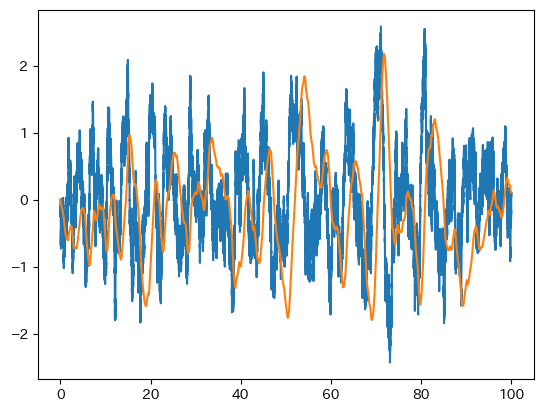

In [137]:
Z = linear_Z(100,0.001,1)
t = np.linspace(0,100,int(100//0.001))
plt.plot(t,Z[0])
plt.plot(t,Z[1])

In [124]:
def compute_a(theta,k0):
    theta21 = theta[1]
    theta22 = theta[2]
    theta3 = theta[3]
    a0 = 1
    a1 = -theta21
    A0 = np.array([[0,1],[-theta22*theta3,-theta21]])
    An = np.array([np.linalg.matrix_power(A0,n) for n in np.arange(k0+1)])
    x0 = np.array([a0,a1])
    xn = np.einsum('ijk,k->ij',An,x0)
    return xn[:,0]
def compute_b(theta,k0):
    theta21 = theta[1]
    theta22 = theta[2]
    theta3 = theta[3]
    b0 = 0
    b1 = -theta22
    B0 = np.array([[0,1],[-theta22*theta3,-theta21]])
    Bn = np.array([np.linalg.matrix_power(B0,n) for n in np.arange(k0+1)])
    x0 = np.array([b0,b1])
    xn = np.einsum('ijk,k->ij',Bn,x0)
    return xn[:,0]

In [125]:
def compute_s(a,theta, k0):
    theta1 = theta[0]
    theta3 = theta[3]
    
    m = np.arange(k0 + 1)
    k = np.arange(k0 )
    l = np.arange(k0 )
    
    m_grid, k_grid,l_grid = np.meshgrid(m, k, l,indexing='ij')
    valid_mask = (k_grid + l_grid == m_grid)

    m_grid = m_grid*valid_mask
    k_grid = k_grid*valid_mask
    l_grid = l_grid*valid_mask
    
    a_k = a[k_grid] * valid_mask
    a_l = a[l_grid] * valid_mask
    
    fact_11 = 1/((m_grid +1)*scipy.special.factorial(k_grid )*scipy.special.factorial(l_grid))
    fact_12 = 1/((m_grid +2)*scipy.special.factorial(k_grid +1)*scipy.special.factorial(l_grid))
    fact_22 = 1/((m_grid +3)*scipy.special.factorial(k_grid +1)*scipy.special.factorial(l_grid+1))
    
    mat11 = np.einsum('ijk->i',theta1**2 * a_k * a_l* fact_11)
    mat12 = np.einsum('ijk->i',theta1**2 * theta3  * a_k * a_l * fact_12)
    mat22 = np.einsum('ijk->i',theta1**2 * theta3**2 * a_k * a_l * fact_22)
    
    s = np.zeros((k0 + 1, 2, 2))
    s[:, 0, 0] = mat11
    s[:, 0, 1] = mat12
    s[:, 1, 0] = mat12
    s[:, 1, 1] = mat22
    
    return s




In [126]:
import numpy as np
import scipy.special

def calculate_d_e(s):
    k0 = np.shape(s)[0] - 1  # k0を変更
    d = np.zeros_like(s)
    e = np.zeros(k0 + 1)
    
    d[0] = np.linalg.inv(s[0])
    
    for k in range(1, k0 + 1):
        p_idx, q_idx ,r_idx= np.meshgrid(np.arange(k), np.arange(k),np.arange(k), indexing='ij')
        valid_indices = (p_idx+q_idx+r_idx == k-1)
                
        p_valid = p_idx[valid_indices]
        q_valid = q_idx[valid_indices]
        r_valid = r_idx[valid_indices]
        
        comb_factor = 1/ (k *scipy.special.factorial(p_valid) * scipy.special.factorial(q_valid) * scipy.special.factorial(r_valid))
        
        d[k] =  -np.einsum('n,nij,njk,nkl->il', comb_factor,d[p_valid], s[q_valid + 1], d[r_valid])
    
    e[0] = np.log(np.linalg.det(s[0]))
    
    for k in range(1, k0 + 1):
        p_idx, q_idx = np.meshgrid(np.arange(k),np.arange(k),indexing = 'ij')
        valid_indices = (p_idx+q_idx == k-1)
        p_valid = p_idx[valid_indices]
        q_valid = q_idx[valid_indices]
        
        comb_factor = 1 / (k* scipy.special.factorial(p_valid) * scipy.special.factorial(q_valid))
        e[k] = -np.einsum('n,nij,nij->', comb_factor, d[p_valid + 1], s[q_valid])
        
    return d, e


In [127]:
def D(a,b,Z,theta,k0,h):
    theta1 = theta[0]
    theta21 = theta[1]
    theta22 = theta[2]
    theta3 = theta[3]
    Z1 = Z[:,1:]
    Z2 = Z[:,:-1]
    x = Z1[0]
    y = Z1[1]
    x_ = Z2[0]
    y_ = Z2[1]
    x = x[:,np.newaxis]
    y = y[:,np.newaxis]
    x_ = x_[:,np.newaxis]
    y_ = y_[:,np.newaxis]
    k = np.arange(1,k0+1)
    f = np.sum((a[k]* x_ + b[k] * y_ )* h**k/scipy.special.factorial(k),axis =1)
    k = np.arange(1,k0+2)
    g = np.sum(theta3*(a[k-1] * x_ +  b[k-1] *y_) * h**k/scipy.special.factorial(k),axis = 1)
    x = Z1[0]
    y = Z1[1]
    x_ = Z2[0]
    y_ = Z2[1]
    Dx = h**(-1/2) *(x - x_ - f)
    Dy = h**(-3/2) *(y - y_ - g)
    return np.array([Dx,Dy])

In [129]:
def QL(Z,theta,k0,h):
    a = compute_a(theta,k0)
    b = compute_b(theta,k0)
    s = compute_s(a,theta,k0)
    d, e = calculate_d_e(s)
    D_ = D(a,b,Z,theta,k0,h)
    k = np.arange(k0+1)
    Q = - np.einsum('k,kj->',h**k, (np.einsum('kpq,pj,qj->kj ',d,D_,D_) + e[:,np.newaxis]))/2
    return Q

In [161]:
t_max = 100.0  # 最大時間の例
h = 0.001
# bounds = scipy.optimize.Bounds([10**(-4),10**(-4),10**(-4),10**(-4)],[10,10,10,10])
bounds = scipy.optimize.Bounds([10**(-2),10**(-2),10**(-2),10**(-2)],[2,2,2,2])
results1 = []
results2 = []
results3 = []
results4 = []
results5 = []
results10 = []
for seed in tqdm.tqdm(range(10)):
    Z = linear_Z(t_max,h,seed)
    result1 = scipy.optimize.minimize(lambda theta: -QL(Z,theta,1,h),[0.5,0.5,0.5,0.5],bounds = bounds,method = 'L-BFGS-B')
    result2 = scipy.optimize.minimize(lambda theta: -QL(Z,theta,2,h),[0.5,0.5,0.5,0.5],bounds = bounds,method = 'L-BFGS-B')
    result3 = scipy.optimize.minimize(lambda theta: -QL(Z,theta,3,h),[0.5,0.5,0.5,0.5],bounds = bounds,method = 'L-BFGS-B')
    result4 = scipy.optimize.minimize(lambda theta: -QL(Z,theta,4,h),[0.5,0.5,0.5,0.5],bounds = bounds,method = 'L-BFGS-B')
    result5 = scipy.optimize.minimize(lambda theta: -QL(Z,theta,5,h),[0.5,0.5,0.5,0.5],bounds = bounds,method = 'L-BFGS-B')
    result10 = scipy.optimize.minimize(lambda theta: -QL(Z,theta,10,h),[0.5,0.5,0.5,0.5],bounds = bounds,method = 'L-BFGS-B')
    results1.append(result1.x)
    results2.append(result2.x)
    results3.append(result3.x)
    results4.append(result4.x)
    results5.append(result5.x)
    results10.append(result10.x)
results1 = np.array(results1)
results2 = np.array(results2)
results3 = np.array(results3)
results4 = np.array(results4)
results5 = np.array(results5)
results10 = np.array(results10)

#resultの平均，標準偏差を表にして表示，インデックスがk，カラムがtheta
import pandas as pd
df = pd.DataFrame(np.vstack([np.mean(results1,axis = 0),np.std(results1,axis = 0),np.mean(results2,axis = 0),np.std(results2,axis = 0),np.mean(results3,axis = 0),np.std(results3,axis = 0),np.mean(results4,axis = 0),np.std(results4,axis = 0),np.mean(results5,axis = 0),np.std(results5,axis = 0),np.mean(results10,axis = 0),np.std(results10,axis = 0)]).T)
df.columns = ['k=1 mean','k=1 std','k=2 mean','k=2 std','k=3 mean','k=3 std','k=4 mean','k=4 std','k=5 mean','k=5 std','k=10 mean','k=10 std']
df.index = ['theta1','theta2','theta3','theta4']
df = df.T
# df.to_csv('nh100h001_M.csv')
df

100%|██████████| 10/10 [06:01<00:00, 36.11s/it]


,theta1,theta2,theta3,theta4
k=1 mean,1.029301,0.789409,0.849722,0.999909
k=1 std,0.001557,0.274968,0.217989,0.000051
k=2 mean,1.029431,0.473678,0.884975,0.999909
k=2 std,0.001521,0.283633,0.192162,0.000051
k=3 mean,1.029430,0.473665,0.932858,0.999909
k=3 std,0.001521,0.283602,0.154421,0.000051
k=4 mean,1.029427,0.473672,0.983312,0.999909
k=4 std,0.001521,0.283602,0.063644,0.000051
k=5 mean,1.029427,0.473716,0.983362,0.999909
k=5 std,0.001521,0.283686,0.063537,0.000051


In [ ]:
theta = [1,1,1,1]  
t_max = 100.0  # 最大時間の例
dt = 0.0001
h = 0.1
# bounds = scipy.optimize.Bounds([10**(-4),10**(-4),10**(-4),10**(-4)],[10,10,10,10])
bounds = scipy.optimize.Bounds([10**(-2),10**(-2),10**(-2),10**(-2)],[2,2,2,2])
results1 = []
results2 = []
results3 = []
results4 = []
results5 = []
results10 = []
for seed in tqdm.tqdm(range(10)):
    Z_t = linear_Z(theta, t_max, dt, seed)
    Z = Z_t[:,::int(h/dt)]
    result1 = scipy.optimize.minimize(lambda theta: -QL(Z,theta,1,h),[0.5,0.5,0.5,0.5],bounds = bounds,method = 'L-BFGS-B')
    result2 = scipy.optimize.minimize(lambda theta: -QL(Z,theta,2,h),[0.5,0.5,0.5,0.5],bounds = bounds,method = 'L-BFGS-B')
    result3 = scipy.optimize.minimize(lambda theta: -QL(Z,theta,3,h),[0.5,0.5,0.5,0.5],bounds = bounds,method = 'L-BFGS-B')
    result4 = scipy.optimize.minimize(lambda theta: -QL(Z,theta,4,h),[0.5,0.5,0.5,0.5],bounds = bounds,method = 'L-BFGS-B')
    result5 = scipy.optimize.minimize(lambda theta: -QL(Z,theta,5,h),[0.5,0.5,0.5,0.5],bounds = bounds,method = 'L-BFGS-B')
    result10 = scipy.optimize.minimize(lambda theta: -QL(Z,theta,10,h),[0.5,0.5,0.5,0.5],bounds = bounds,method = 'L-BFGS-B')
    results1.append(result1.x)
    results2.append(result2.x)
    results3.append(result3.x)
    results4.append(result4.x)
    results5.append(result5.x)
    results10.append(result10.x)
results1 = np.array(results1)
results2 = np.array(results2)
results3 = np.array(results3)
results4 = np.array(results4)
results5 = np.array(results5)
results10 = np.array(results10)

#resultの平均，標準偏差を表にして表示，インデックスがk，カラムがtheta
import pandas as pd
df = pd.DataFrame(np.vstack([np.mean(results1,axis = 0),np.std(results1,axis = 0),np.mean(results2,axis = 0),np.std(results2,axis = 0),np.mean(results3,axis = 0),np.std(results3,axis = 0),np.mean(results4,axis = 0),np.std(results4,axis = 0),np.mean(results5,axis = 0),np.std(results5,axis = 0),np.mean(results10,axis = 0),np.std(results10,axis = 0)]).T)
df.columns = ['k=1 mean','k=1 std','k=2 mean','k=2 std','k=3 mean','k=3 std','k=4 mean','k=4 std','k=5 mean','k=5 std','k=10 mean','k=10 std']
df.index = ['theta1','theta2','theta3','theta4']
df = df.T
# df.to_csv('nh100h001_M.csv')
df

100%|██████████| 10/10 [00:08<00:00,  1.15it/s]


,theta1,theta2,theta3,theta4
k=1 mean,0.972338,0.946897,0.928961,1.000935
k=1 std,0.015975,0.086394,0.139191,0.003683
k=2 mean,0.994488,0.906227,0.974382,1.000057
k=2 std,0.015628,0.093733,0.145119,0.003634
k=3 mean,0.994508,0.904047,0.970692,1.000091
k=3 std,0.015631,0.092308,0.144574,0.003636
k=4 mean,0.994512,0.904080,0.970551,1.000091
k=4 std,0.015628,0.092284,0.144539,0.003636
k=5 mean,0.994512,0.904084,0.970555,1.000091
k=5 std,0.015628,0.092285,0.144541,0.003636


In [71]:
theta = [1,1,1,1]  
t_max = 100.0  # 最大時間の例
h = 0.5
# bounds = scipy.optimize.Bounds([10**(-4),10**(-4),10**(-4),10**(-4)],[10,10,10,10])
bounds = scipy.optimize.Bounds([10**(-2),10**(-2),10**(-2),10**(-2)],[2,2,2,2])
results1 = []
results2 = []
results3 = []
results4 = []
results5 = []
results10 = []
for seed in tqdm.tqdm(range(10)):
    Z = linear_Z( t_max, h, seed)
    result1 = scipy.optimize.minimize(lambda theta: -QL(Z,theta,1,h),[0.5,0.5,0.5,0.5],bounds = bounds,method = 'L-BFGS-B')
    result2 = scipy.optimize.minimize(lambda theta: -QL(Z,theta,2,h),[0.5,0.5,0.5,0.5],bounds = bounds,method = 'L-BFGS-B')
    result3 = scipy.optimize.minimize(lambda theta: -QL(Z,theta,3,h),[0.5,0.5,0.5,0.5],bounds = bounds,method = 'L-BFGS-B')
    result4 = scipy.optimize.minimize(lambda theta: -QL(Z,theta,4,h),[0.5,0.5,0.5,0.5],bounds = bounds,method = 'L-BFGS-B')
    result5 = scipy.optimize.minimize(lambda theta: -QL(Z,theta,5,h),[0.5,0.5,0.5,0.5],bounds = bounds,method = 'L-BFGS-B')
    result10 = scipy.optimize.minimize(lambda theta: -QL(Z,theta,10,h),[0.5,0.5,0.5,0.5],bounds = bounds,method = 'L-BFGS-B')
    results1.append(result1.x)
    results2.append(result2.x)
    results3.append(result3.x)
    results4.append(result4.x)
    results5.append(result5.x)
    results10.append(result10.x)
results1 = np.array(results1)
results2 = np.array(results2)
results3 = np.array(results3)
results4 = np.array(results4)
results5 = np.array(results5)
results10 = np.array(results10)

#resultの平均，標準偏差を表にして表示，インデックスがk，カラムがtheta
import pandas as pd
df = pd.DataFrame(np.vstack([np.mean(results1,axis = 0),np.std(results1,axis = 0),np.mean(results2,axis = 0),np.std(results2,axis = 0),np.mean(results3,axis = 0),np.std(results3,axis = 0),np.mean(results4,axis = 0),np.std(results4,axis = 0),np.mean(results5,axis = 0),np.std(results5,axis = 0),np.mean(results10,axis = 0),np.std(results10,axis = 0)]).T)
df.columns = ['k=1 mean','k=1 std','k=2 mean','k=2 std','k=3 mean','k=3 std','k=4 mean','k=4 std','k=5 mean','k=5 std','k=10 mean','k=10 std']
df.index = ['theta1','theta2','theta3','theta4']
df = df.T
# df.to_csv('nh100h001_M.csv')
df

  0%|          | 0/10 [00:00<?, ?it/s]/var/folders/db/b1td2bb97db6ppr5q5fk5_xc0000gn/T/ipykernel_7004/1608982747.py:8: RuntimeWarning: covariance is not positive-semidefinite.
  Z[i]  = np.dot(Exp,Z[i-1]) + np.random.multivariate_normal([0,0],Var)
100%|██████████| 10/10 [00:01<00:00,  5.04it/s]


,theta1,theta2,theta3,theta4
k=1 mean,1.114427,0.500000,1.000000e-02,1.996167
k=1 std,0.813025,0.000000,1.734723e-18,0.011500
k=2 mean,1.092454,1.850594,1.447172e+00,1.984307
k=2 std,0.816396,0.448219,8.521261e-01,0.031390
k=3 mean,1.091341,1.942566,1.602000e+00,2.000000
k=3 std,0.816523,0.070642,7.960000e-01,0.000000
k=4 mean,1.096683,2.000000,1.444635e+00,2.000000
k=4 std,0.815430,0.000000,8.551187e-01,0.000000
k=5 mean,1.095835,2.000000,1.458165e+00,2.000000
k=5 std,0.815591,0.000000,8.398334e-01,0.000000


In [155]:
theta = [1,1,1,1]  
t_max = 100.0  # 最大時間の例
h = 0.9
# bounds = scipy.optimize.Bounds([10**(-4),10**(-4),10**(-4),10**(-4)],[10,10,10,10])
bounds = scipy.optimize.Bounds([10**(-2),10**(-2),10**(-2),10**(-2)],[2,2,2,2])
results1 = []
results2 = []
results3 = []
results4 = []
results5 = []
results10 = []
for seed in tqdm.tqdm(range(10)):
    Z = linear_Z(t_max,h, seed)
    result1 = scipy.optimize.minimize(lambda theta: -QL(Z,theta,1,h),[0.5,0.5,0.5,0.5],bounds = bounds,method = 'L-BFGS-B')
    result2 = scipy.optimize.minimize(lambda theta: -QL(Z,theta,2,h),[0.5,0.5,0.5,0.5],bounds = bounds,method = 'L-BFGS-B')
    result3 = scipy.optimize.minimize(lambda theta: -QL(Z,theta,3,h),[0.5,0.5,0.5,0.5],bounds = bounds,method = 'L-BFGS-B')
    result4 = scipy.optimize.minimize(lambda theta: -QL(Z,theta,4,h),[0.5,0.5,0.5,0.5],bounds = bounds,method = 'L-BFGS-B')
    result5 = scipy.optimize.minimize(lambda theta: -QL(Z,theta,5,h),[0.5,0.5,0.5,0.5],bounds = bounds,method = 'L-BFGS-B')
    result10 = scipy.optimize.minimize(lambda theta: -QL(Z,theta,10,h),[0.5,0.5,0.5,0.5],bounds = bounds,method = 'L-BFGS-B')
    results1.append(result1.x)
    results2.append(result2.x)
    results3.append(result3.x)
    results4.append(result4.x)
    results5.append(result5.x)
    results10.append(result10.x)
results1 = np.array(results1)
results2 = np.array(results2)
results3 = np.array(results3)
results4 = np.array(results4)
results5 = np.array(results5)
results10 = np.array(results10)

#resultの平均，標準偏差を表にして表示，インデックスがk，カラムがtheta
import pandas as pd
df = pd.DataFrame(np.vstack([np.mean(results1,axis = 0),np.std(results1,axis = 0),np.mean(results2,axis = 0),np.std(results2,axis = 0),np.mean(results3,axis = 0),np.std(results3,axis = 0),np.mean(results4,axis = 0),np.std(results4,axis = 0),np.mean(results5,axis = 0),np.std(results5,axis = 0),np.mean(results10,axis = 0),np.std(results10,axis = 0)]).T)
df.columns = ['k=1 mean','k=1 std','k=2 mean','k=2 std','k=3 mean','k=3 std','k=4 mean','k=4 std','k=5 mean','k=5 std','k=10 mean','k=10 std']
df.index = ['theta1','theta2','theta3','theta4']
df = df.T
# df.to_csv('nh100h001_M.csv')
df

100%|██████████| 10/10 [03:49<00:00, 22.92s/it]


,theta1,theta2,theta3,theta4
k=1 mean,0.826596,0.858918,0.573842,1.015680
k=1 std,0.027427,0.094860,0.089008,0.066670
k=2 mean,0.984952,0.888645,0.906728,0.938433
k=2 std,0.035066,0.076520,0.098377,0.056904
k=3 mean,0.936410,0.576536,0.990487,0.947915
k=3 std,0.034456,0.041812,0.169133,0.057922
k=4 mean,0.940175,0.580856,0.900774,0.952829
k=4 std,0.035831,0.048943,0.153162,0.059418
k=5 mean,0.941150,0.585117,0.898197,0.952111
k=5 std,0.035640,0.047282,0.146941,0.059217


In [159]:
theta = [1,1,1,1]  
t_max = 100.0  # 最大時間の例
h = 0.9
# bounds = scipy.optimize.Bounds([10**(-4),10**(-4),10**(-4),10**(-4)],[10,10,10,10])
bounds = scipy.optimize.Bounds([10**(-2),10**(-2),10**(-2),10**(-2)],[2,2,2,2])
results1 = []
results2 = []
results3 = []
results4 = []
results5 = []
results10 = []
for seed in tqdm.tqdm(range(1)):
    Z = linear_Z(t_max,h, seed)
    result1 = scipy.optimize.minimize(lambda theta: -QL(Z,theta,1,h),[0.5,0.5,0.5,0.5],bounds = bounds,method = 'L-BFGS-B')
    result2 = scipy.optimize.minimize(lambda theta: -QL(Z,theta,2,h),[0.5,0.5,0.5,0.5],bounds = bounds,method = 'L-BFGS-B')
    result3 = scipy.optimize.minimize(lambda theta: -QL(Z,theta,3,h),[0.5,0.5,0.5,0.5],bounds = bounds,method = 'L-BFGS-B')
    result4 = scipy.optimize.minimize(lambda theta: -QL(Z,theta,4,h),[0.5,0.5,0.5,0.5],bounds = bounds,method = 'L-BFGS-B')
    result5 = scipy.optimize.minimize(lambda theta: -QL(Z,theta,5,h),[0.5,0.5,0.5,0.5],bounds = bounds,method = 'L-BFGS-B')
    result10 = scipy.optimize.minimize(lambda theta: -QL(Z,theta,10,h),[0.5,0.5,0.5,0.5],bounds = bounds,method = 'L-BFGS-B')
    results1.append(result1.x)
    results2.append(result2.x)
    results3.append(result3.x)
    results4.append(result4.x)
    results5.append(result5.x)
    results10.append(result10.x)
results1 = np.array(results1)
results2 = np.array(results2)
results3 = np.array(results3)
results4 = np.array(results4)
results5 = np.array(results5)
results10 = np.array(results10)

#resultの平均，標準偏差を表にして表示，インデックスがk，カラムがtheta
import pandas as pd
df = pd.DataFrame(np.vstack([np.mean(results1,axis = 0),np.std(results1,axis = 0),np.mean(results2,axis = 0),np.std(results2,axis = 0),np.mean(results3,axis = 0),np.std(results3,axis = 0),np.mean(results4,axis = 0),np.std(results4,axis = 0),np.mean(results5,axis = 0),np.std(results5,axis = 0),np.mean(results10,axis = 0),np.std(results10,axis = 0)]).T)
df.columns = ['k=1 mean','k=1 std','k=2 mean','k=2 std','k=3 mean','k=3 std','k=4 mean','k=4 std','k=5 mean','k=5 std','k=10 mean','k=10 std']
df.index = ['theta1','theta2','theta3','theta4']
df = df.T
# df.to_csv('nh100h001_M.csv')
df

100%|██████████| 1/1 [03:51<00:00, 231.38s/it]


,theta1,theta2,theta3,theta4
k=1 mean,0.803882,0.786796,0.778328,0.987312
k=1 std,0.000000,0.000000,0.000000,0.000000
k=2 mean,0.947122,0.755223,1.030278,0.906016
k=2 std,0.000000,0.000000,0.000000,0.000000
k=3 mean,0.897867,0.514120,1.309260,0.908044
k=3 std,0.000000,0.000000,0.000000,0.000000
k=4 mean,0.897223,0.493310,1.207357,0.918422
k=4 std,0.000000,0.000000,0.000000,0.000000
k=5 mean,0.899537,0.499802,1.188861,0.917381
k=5 std,0.000000,0.000000,0.000000,0.000000


In [54]:
theta = [1,1,1,1]  
t_max = 10.0  # 最大時間の例
dt = 0.0001
h = 0.99
# bounds = scipy.optimize.Bounds([10**(-4),10**(-4),10**(-4),10**(-4)],[10,10,10,10])
bounds = scipy.optimize.Bounds([10**(-2),10**(-2),10**(-2),10**(-2)],[2,2,2,2])
results1 = []
results2 = []
results3 = []
results4 = []
results5 = []
results10 = []
for seed in tqdm.tqdm(range(100)):
    Z_t = linear_Z(theta, t_max, dt, seed)
    Z = Z_t[:,::int(h/dt)]
    result1 = scipy.optimize.minimize(lambda theta: -QL(Z,theta,1,h),[0.5,0.5,0.5,0.5],bounds = bounds,method = 'L-BFGS-B')
    result2 = scipy.optimize.minimize(lambda theta: -QL(Z,theta,2,h),[0.5,0.5,0.5,0.5],bounds = bounds,method = 'L-BFGS-B')
    result3 = scipy.optimize.minimize(lambda theta: -QL(Z,theta,3,h),[0.5,0.5,0.5,0.5],bounds = bounds,method = 'L-BFGS-B')
    result4 = scipy.optimize.minimize(lambda theta: -QL(Z,theta,4,h),[0.5,0.5,0.5,0.5],bounds = bounds,method = 'L-BFGS-B')
    result5 = scipy.optimize.minimize(lambda theta: -QL(Z,theta,5,h),[0.5,0.5,0.5,0.5],bounds = bounds,method = 'L-BFGS-B')
    result10 = scipy.optimize.minimize(lambda theta: -QL(Z,theta,10,h),[0.5,0.5,0.5,0.5],bounds = bounds,method = 'L-BFGS-B')
    results1.append(result1.x)
    results2.append(result2.x)
    results3.append(result3.x)
    results4.append(result4.x)
    results5.append(result5.x)
    results10.append(result10.x)
results1 = np.array(results1)
results2 = np.array(results2)
results3 = np.array(results3)
results4 = np.array(results4)
results5 = np.array(results5)
results10 = np.array(results10)

#resultの平均，標準偏差を表にして表示，インデックスがk，カラムがtheta
import pandas as pd
df = pd.DataFrame(np.vstack([np.mean(results1,axis = 0),np.std(results1,axis = 0),np.mean(results2,axis = 0),np.std(results2,axis = 0),np.mean(results3,axis = 0),np.std(results3,axis = 0),np.mean(results4,axis = 0),np.std(results4,axis = 0),np.mean(results5,axis = 0),np.std(results5,axis = 0),np.mean(results10,axis = 0),np.std(results10,axis = 0)]).T)
df.columns = ['k=1 mean','k=1 std','k=2 mean','k=2 std','k=3 mean','k=3 std','k=4 mean','k=4 std','k=5 mean','k=5 std','k=10 mean','k=10 std']
df.index = ['theta1','theta21','theta22','theta3']
df = df.T
# df.to_csv('nh100h001_M.csv')
df

100%|██████████| 100/100 [00:24<00:00,  4.04it/s]


,theta1,theta21,theta22,theta3
k=1 mean,0.745777,0.928451,0.615027,1.089059
k=1 std,0.155339,0.307534,0.332493,0.233147
k=2 mean,0.924243,0.992852,1.130827,0.953481
k=2 std,0.209223,0.448171,0.483216,0.168950
k=3 mean,0.856247,0.514811,1.166119,0.974154
k=3 std,0.180603,0.214424,0.510142,0.179776
k=4 mean,0.866113,0.525295,1.029847,0.983083
k=4 std,0.185210,0.230629,0.471998,0.193434
k=5 mean,0.869225,0.544291,1.009422,0.981154
k=5 std,0.183533,0.226692,0.445931,0.188135


他の真値で試してみる

In [62]:
theta = [1,5,1,1]  
t_max = 100.0  # 最大時間の例
dt = 0.0001
h = 0.01
# bounds = scipy.optimize.Bounds([10**(-4),10**(-4),10**(-4),10**(-4)],[10,10,10,10])
bounds = scipy.optimize.Bounds([10**(-2),10**(-2),10**(-2),10**(-2)],[10,10,10,10])
results1 = []
results2 = []
results3 = []
results4 = []
results5 = []
results10 = []
for seed in tqdm.tqdm(range(10)):
    Z_t = linear_Z(theta, t_max, dt, seed)
    Z = Z_t[:,::int(h/dt)]
    result1 = scipy.optimize.minimize(lambda theta: -QL(Z,theta,1,h),[0.5,5,0.5,0.5],bounds = bounds,method = 'L-BFGS-B')
    result2 = scipy.optimize.minimize(lambda theta: -QL(Z,theta,2,h),[0.5,3,0.5,0.5],bounds = bounds,method = 'L-BFGS-B')
    result3 = scipy.optimize.minimize(lambda theta: -QL(Z,theta,3,h),[0.5,3,0.5,0.5],bounds = bounds,method = 'L-BFGS-B')
    result4 = scipy.optimize.minimize(lambda theta: -QL(Z,theta,4,h),[0.5,3,0.5,0.5],bounds = bounds,method = 'L-BFGS-B')
    result5 = scipy.optimize.minimize(lambda theta: -QL(Z,theta,5,h),[0.5,3,0.5,0.5],bounds = bounds,method = 'L-BFGS-B')
    result10 = scipy.optimize.minimize(lambda theta: -QL(Z,theta,10,h),[0.5,3,0.5,0.5],bounds = bounds,method = 'L-BFGS-B')
    results1.append(result1.x)
    results2.append(result2.x)
    results3.append(result3.x)
    results4.append(result4.x)
    results5.append(result5.x)
    results10.append(result10.x)
results1 = np.array(results1)
results2 = np.array(results2)
results3 = np.array(results3)
results4 = np.array(results4)
results5 = np.array(results5)
results10 = np.array(results10)

#resultの平均，標準偏差を表にして表示，インデックスがk，カラムがtheta
import pandas as pd
df = pd.DataFrame(np.vstack([np.mean(results1,axis = 0),np.std(results1,axis = 0),np.mean(results2,axis = 0),np.std(results2,axis = 0),np.mean(results3,axis = 0),np.std(results3,axis = 0),np.mean(results4,axis = 0),np.std(results4,axis = 0),np.mean(results5,axis = 0),np.std(results5,axis = 0),np.mean(results10,axis = 0),np.std(results10,axis = 0)]).T)
df.columns = ['k=1 mean','k=1 std','k=2 mean','k=2 std','k=3 mean','k=3 std','k=4 mean','k=4 std','k=5 mean','k=5 std','k=10 mean','k=10 std']
df.index = ['theta1','theta2','theta3','theta4']
df = df.T
# df.to_csv('nh100h001_M.csv')
df

100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


,theta1,theta2,theta3,theta4
k=1 mean,0.5,5.0,0.5,0.5
k=1 std,0.0,0.0,0.0,0.0
k=2 mean,0.5,3.0,0.5,0.5
k=2 std,0.0,0.0,0.0,0.0
k=3 mean,0.5,3.0,0.5,0.5
k=3 std,0.0,0.0,0.0,0.0
k=4 mean,0.5,3.0,0.5,0.5
k=4 std,0.0,0.0,0.0,0.0
k=5 mean,0.5,3.0,0.5,0.5
k=5 std,0.0,0.0,0.0,0.0


theta21の図形を調べる

/var/folders/db/b1td2bb97db6ppr5q5fk5_xc0000gn/T/ipykernel_7004/3355648782.py:9: RuntimeWarning: covariance is not positive-semidefinite.
  Z[i]  = np.dot(Exp,Z[i-1]) + np.random.multivariate_normal([0,0],Var)


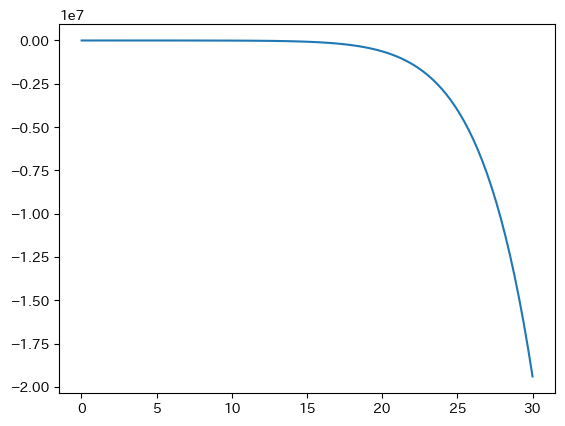

In [123]:
theta = [1,1,1,1]  
t_max = 100.0
h = 0.2  # 最大時間の例
Z = linear_Z(t_max, h, 5)
theta2 = np.linspace(0.01,30,100)
Q_list = theta2.copy()
for i in range(100):
    Q_list[i] = QL(Z,np.array([1,theta2[i],1,1]),3,h)
plt.plot(theta2,Q_list)

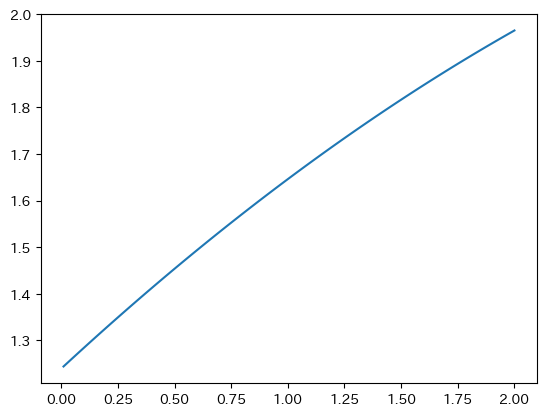

In [79]:
theta = [1,1,1,1]  
t_max = 100.0
dt = 0.0001  # 最大時間の例
h = 0.9
Z = linear_Z(t_max, dt, 3)
theta2 = np.linspace(0.01,2,100)
Q_list = theta2.copy()
for i in range(100):
    Q_list[i] = QL(Z,np.array([1,theta2[i],1,1]),2,h)
plt.plot(theta2,Q_list)

$k_0 = 3$でargmaxが1からズレる

In [76]:
theta = [1,0.5,1,1]  
t_max = 100.0
dt = 0.0001  # 最大時間の例
h_list = [0.9,0.5,0.1,0.01]
k_list = [1,2,3,4,5,10]
df = pd.DataFrame(columns= 'h=0.9,h=0.5,h=0.1,h=0.01'.split(','),index = 'k=1,k=2,k=3,k=4,k=5,k=10'.split(','))
for h in tqdm.tqdm(h_list):
    for k in k_list:
        _list_ = []
        for seed in range(10,15):
            Z_t = linear_Z(theta, t_max, dt, seed)
            Z = Z_t[:,::int(h//dt)]
            theta2 = np.linspace(0.01,2,200)
            Q_list = theta2.copy()
            def QL2(theta2):
                return QL(Z,np.array([1,theta2,1,1]),k,h)
            QL2 = np.vectorize(QL2)
            Q_list = QL2(theta2)
            index = np.argmax(Q_list)
            _list_.append(theta2[index])
        _list_ = np.array(_list_)
        df.loc[f'k={k}',f'h={h}'] = np.mean(_list_)

    

100%|██████████| 4/4 [00:56<00:00, 14.03s/it]


In [77]:
df

,h=0.9,h=0.5,h=0.1,h=0.01
k=1,0.69,0.608,0.494,0.468
k=2,0.466,0.422,0.45,0.47
k=3,0.356,0.396,0.45,0.47
k=4,0.354,0.396,0.448,0.47
k=5,0.358,0.396,0.448,0.47
k=10,0.36,0.396,0.448,0.47


ベイズ推定をメトロポリス法により実行する

In [36]:
import numpy as np
import matplotlib.pyplot as plt

def target_distribution_1(x,alpha,theta21,theta22,theta3,k0,Z,n,h):
    if 0.0001 <= x <= 10:
        return np.log(1 / (2 - 0.1)) + QL(Z, [x, theta21, theta22, theta3], k0, h)/(alpha**2)/(n)
    else:
        return -np.inf
def target_distribution_2(x,alpha,theta1,theta3,k0,Z,n,h):
    if np.all((0.01 <= x[0]) & (x[0] <= 2) & (0.01 <= x[1]) & (x[1] <= 2)):
        return np.log(1 / (2 - 0.01)**2) + QL(Z, np.array([theta1, x[0], x[1], theta3]), k0, h)/(alpha**2)/(n*h)
    else:
        return -np.inf
def target_distribution_3(x,alpha,theta1,theta21,theta22,k0,Z,n,h):
    if 0.0001 <= x <= 10:
        return np.log(1 / (10 - 0.0001)) + QL(Z, [theta1, theta21, theta22, x], k0, h)/(alpha**2)/(n/h)
    else:
        return -np.inf

def metropolis_hastings(func, n_samples, proposal_std,m):
    samples = np.zeros((n_samples, m))
    current_x = 0.5*np.ones(m)
    current_log_y = func(current_x)
    accepted = 0

    for i in range(n_samples):
        proposed_x = np.random.multivariate_normal(current_x,proposal_std*np.eye(m))
        proposed_log_y = func(proposed_x)
        acceptance_ratio = np.exp(proposed_log_y - current_log_y)

        if np.random.random() < acceptance_ratio:
            current_x = proposed_x
            current_log_y = proposed_log_y
            accepted += 1

        samples[i] = current_x

    acceptance_rate = accepted / n_samples
    return samples, acceptance_rate


$k_0 =1$

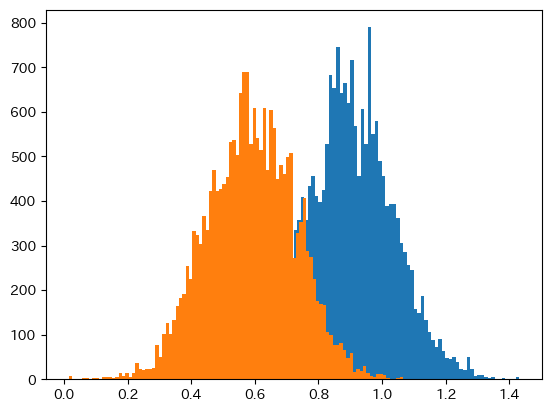

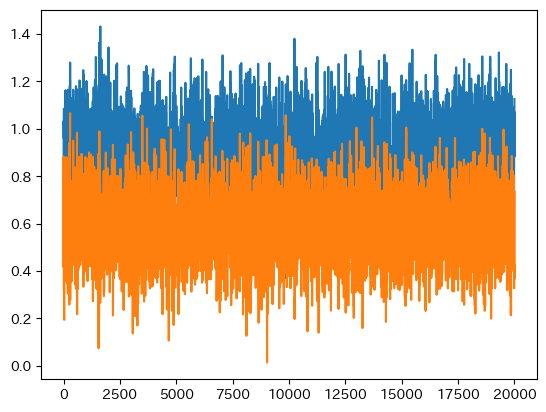

[0.89593102 0.58760047]


In [38]:
theta = [1,1,1,1]  
t_max = 100.0
dt = 0.0001  # 最大時間の例
h = 0.9
Z_t = linear_Z(theta, t_max, dt, 3)
Z = Z_t[:,::int(h//dt)]
n = t_max/h
k_0 = 1
samples1, acceptance_rate1 = metropolis_hastings(lambda x: target_distribution_2(x,(1/(n*h))**(1/2), 1,1,k_0,Z,n,h), 20000, 0.1,2)
plt.hist(samples1[:,0],bins = 100)
plt.hist(samples1[:,1],bins = 100)
plt.show()
plt.plot(samples1[:,0])
plt.plot(samples1[:,1])
plt.show()
print(samples1.mean(axis = 0))

$k_0 =2$

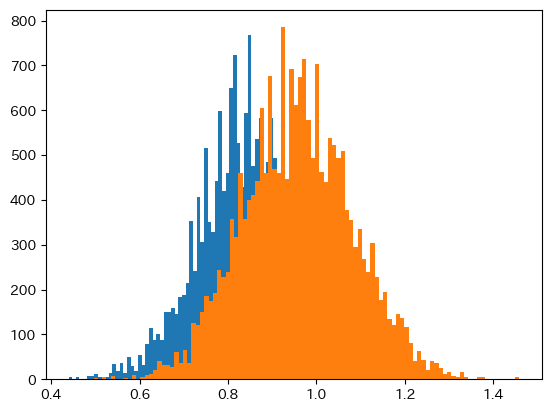

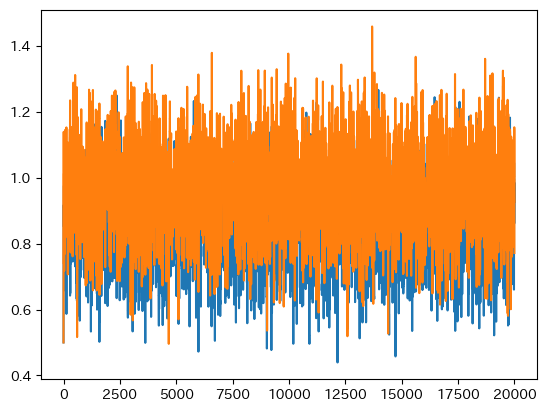

[0.85610148 0.95894427]


In [39]:
theta = [1,1,1,1]  
t_max = 100.0
dt = 0.0001  # 最大時間の例
h = 0.9
Z_t = linear_Z(theta, t_max, dt, 3)
Z = Z_t[:,::int(h//dt)]
n = t_max/h
k_0 = 2
samples1, acceptance_rate1 = metropolis_hastings(lambda x: target_distribution_2(x,(1/(n*h))**(1/2), 1,1,k_0,Z,n,h), 20000, 0.1,2)
plt.hist(samples1[:,0],bins = 100)
plt.hist(samples1[:,1],bins = 100)
plt.show()
plt.plot(samples1[:,0])
plt.plot(samples1[:,1])
plt.show()
print(samples1.mean(axis = 0))

$k_0= 3$

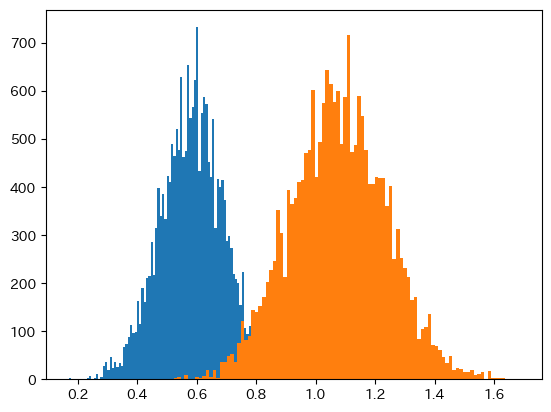

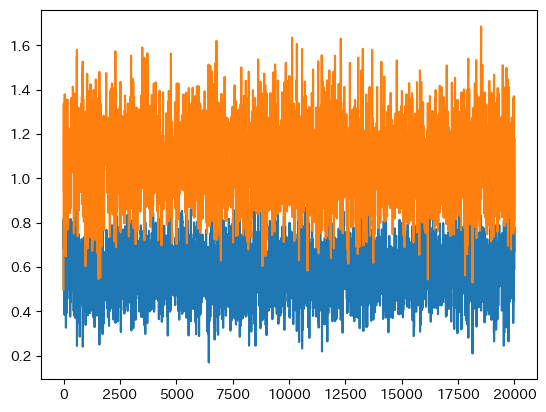

[0.58513664 1.07684278]


In [40]:
theta = [1,1,1,1]  
t_max = 100.0
dt = 0.0001  # 最大時間の例
h = 0.9
Z_t = linear_Z(theta, t_max, dt, 3)
Z = Z_t[:,::int(h//dt)]
n = t_max/h
k_0 = 3
samples1, acceptance_rate1 = metropolis_hastings(lambda x: target_distribution_2(x,(1/(n*h))**(1/2), 1,1,k_0,Z,n,h), 20000, 0.1,2)
plt.hist(samples1[:,0],bins = 100)
plt.hist(samples1[:,1],bins = 100)
plt.show()
plt.plot(samples1[:,0])
plt.plot(samples1[:,1])
plt.show()
print(samples1.mean(axis = 0))

In [405]:
samples1_list = []
samples2_list = []
samples3_list = []
samples4_list = []
samples5_list = []
samples10_list = []
for seed in tqdm.tqdm(range(10)):
    theta = [1,1,1,1]  
    t_max = 100.0
    dt = 0.0001  # 最大時間の例
    h = 0.01
    Z_t = linear_Z(theta, t_max, dt, seed)
    Z = Z_t[:,::int(h//dt)]
    n = t_max/h
    samples1, acceptance_rate1 = metropolis_hastings(lambda x: target_distribution_2(x,(1/(n*h))**(1/2), 1,1,1,Z,n,h), 2000, 0.1,2)
    samples1_list.append(samples1[200:].mean(axis = 0))
    samples2, acceptance_rate2 = metropolis_hastings(lambda x: target_distribution_2(x,(1/(n*h))**(1/2), 1,1,2,Z,n,h), 2000, 0.1,2)
    samples2_list.append(samples2[200:].mean(axis = 0))
    samples3, acceptance_rate3 = metropolis_hastings(lambda x: target_distribution_2(x,(1/(n*h))**(1/2), 1,1,3,Z,n,h), 2000, 0.1,2)
    samples3_list.append(samples3[200:].mean(axis = 0))
    samples4, acceptance_rate4 = metropolis_hastings(lambda x: target_distribution_2(x,(1/(n*h))**(1/2), 1,1,4,Z,n,h), 2000, 0.1,2)
    samples4_list.append(samples4[200:].mean(axis = 0))
    samples5, acceptance_rate5 = metropolis_hastings(lambda x: target_distribution_2(x,(1/(n*h))**(1/2), 1,1,5,Z,n,h), 2000, 0.1,2)
    samples5_list.append(samples5[200:].mean(axis = 0))
    samples10, acceptance_rate10 = metropolis_hastings(lambda x: target_distribution_2(x,(1/(n*h))**(1/2), 1,1,10,Z,n,h), 2000, 0.1,2)
    samples10_list.append(samples10[200:].mean(axis = 0))
samples1_list = np.array(samples1_list)
samples2_list = np.array(samples2_list)
samples3_list = np.array(samples3_list)
samples4_list = np.array(samples4_list)
samples5_list = np.array(samples5_list)
import pandas as pd

df = pd.DataFrame(np.vstack([
    np.mean(samples1_list, axis=0),
    np.std(samples1_list, axis=0),
    np.mean(samples2_list, axis=0),
    np.std(samples2_list, axis=0),
    np.mean(samples3_list, axis=0),
    np.std(samples3_list, axis=0),
    np.mean(samples4_list, axis=0),
    np.std(samples4_list, axis=0),
    np.mean(samples5_list, axis=0),
    np.std(samples5_list, axis=0),
    np.mean(samples10_list, axis=0),
    np.std(samples10_list, axis=0)
]).T)

df.columns = [
    'k=1 mean', 'k=1 std',
    'k=2 mean', 'k=2 std',
    'k=3 mean', 'k=3 std',
    'k=4 mean', 'k=4 std',
    'k=5 mean', 'k=5 std',
    'k=10 mean', 'k=10 std'
]
df.index = ['theta1', 'theta2']
df = df.T
df

100%|██████████| 10/10 [02:50<00:00, 17.01s/it]


,theta1,theta2
k=1 mean,0.967065,0.959805
k=1 std,0.114803,0.145620
k=2 mean,0.991472,0.956819
k=2 std,0.112304,0.143031
k=3 mean,0.987977,0.957978
k=3 std,0.112947,0.149662
k=4 mean,0.987164,0.955204
k=4 std,0.117482,0.141154
k=5 mean,0.987453,0.956505
k=5 std,0.112981,0.146831


In [346]:
samples1_list = []
samples2_list = []
samples3_list = []
samples4_list = []
samples5_list = []
samples10_list = []
for seed in tqdm.tqdm(range(10)):
    theta = [1,1,1,1]  
    t_max = 100.0
    dt = 0.0001  # 最大時間の例
    h = 0.05
    Z_t = linear_Z(theta, t_max, dt, seed)
    Z = Z_t[:,::int(h//dt)]
    n = t_max/h
    samples1, acceptance_rate1 = metropolis_hastings(lambda x: target_distribution_2(x,(1/(n*h))**(1/2), 1,1,1,Z,n,h), 2000, 0.1,2)
    samples1_list.append(samples1[200:].mean(axis = 0))
    samples2, acceptance_rate2 = metropolis_hastings(lambda x: target_distribution_2(x,(1/(n*h))**(1/2), 1,1,2,Z,n,h), 2000, 0.1,2)
    samples2_list.append(samples2[200:].mean(axis = 0))
    samples3, acceptance_rate3 = metropolis_hastings(lambda x: target_distribution_2(x,(1/(n*h))**(1/2), 1,1,3,Z,n,h), 2000, 0.1,2)
    samples3_list.append(samples3[200:].mean(axis = 0))
    samples4, acceptance_rate4 = metropolis_hastings(lambda x: target_distribution_2(x,(1/(n*h))**(1/2), 1,1,4,Z,n,h), 2000, 0.1,2)
    samples4_list.append(samples4[200:].mean(axis = 0))
    samples5, acceptance_rate5 = metropolis_hastings(lambda x: target_distribution_2(x,(1/(n*h))**(1/2), 1,1,5,Z,n,h), 2000, 0.1,2)
    samples5_list.append(samples5[200:].mean(axis = 0))
    samples10, acceptance_rate10 = metropolis_hastings(lambda x: target_distribution_2(x,(1/(n*h))**(1/2), 1,1,10,Z,n,h), 2000, 0.1,2)
    samples10_list.append(samples10[200:].mean(axis = 0))
samples1_list = np.array(samples1_list)
samples2_list = np.array(samples2_list)
samples3_list = np.array(samples3_list)
samples4_list = np.array(samples4_list)
samples5_list = np.array(samples5_list)
import pandas as pd

df = pd.DataFrame(np.vstack([
    np.mean(samples1_list, axis=0),
    np.std(samples1_list, axis=0),
    np.mean(samples2_list, axis=0),
    np.std(samples2_list, axis=0),
    np.mean(samples3_list, axis=0),
    np.std(samples3_list, axis=0),
    np.mean(samples4_list, axis=0),
    np.std(samples4_list, axis=0),
    np.mean(samples5_list, axis=0),
    np.std(samples5_list, axis=0),
    np.mean(samples10_list, axis=0),
    np.std(samples10_list, axis=0)
]).T)

df.columns = [
    'k=1 mean', 'k=1 std',
    'k=2 mean', 'k=2 std',
    'k=3 mean', 'k=3 std',
    'k=4 mean', 'k=4 std',
    'k=5 mean', 'k=5 std',
    'k=10 mean', 'k=10 std'
]
df.index = ['theta1', 'theta2']
df = df.T
df

  0%|          | 0/10 [00:00<?, ?it/s]/var/folders/db/b1td2bb97db6ppr5q5fk5_xc0000gn/T/ipykernel_3714/263542008.py:29: RuntimeWarning: overflow encountered in exp
  acceptance_ratio = np.exp(proposed_log_y - current_log_y)
100%|██████████| 10/10 [01:04<00:00,  6.49s/it]


,theta1,theta2
k=1 mean,0.962667,0.952115
k=1 std,0.095646,0.141241
k=2 mean,1.036767,0.977067
k=2 std,0.119141,0.144847
k=3 mean,0.964569,0.984573
k=3 std,0.094644,0.152724
k=4 mean,0.991448,0.978463
k=4 std,0.106000,0.146812
k=5 mean,0.984603,0.977088
k=5 std,0.102648,0.145401


In [345]:
samples1_list = []
samples2_list = []
samples3_list = []
samples4_list = []
samples5_list = []
samples10_list = []
for seed in tqdm.tqdm(range(10)):
    theta = [1,1,1,1]  
    t_max = 100.0
    dt = 0.0001  # 最大時間の例
    h = 0.1
    Z_t = linear_Z(theta, t_max, dt, seed)
    Z = Z_t[:,::int(h//dt)]
    n = t_max/h
    samples1, acceptance_rate1 = metropolis_hastings(lambda x: target_distribution_2(x,(1/(n*h))**(1/2), 1,1,1,Z,n,h), 2000, 0.1,2)
    samples1_list.append(samples1[200:].mean(axis = 0))
    samples2, acceptance_rate2 = metropolis_hastings(lambda x: target_distribution_2(x,(1/(n*h))**(1/2), 1,1,2,Z,n,h), 2000, 0.1,2)
    samples2_list.append(samples2[200:].mean(axis = 0))
    samples3, acceptance_rate3 = metropolis_hastings(lambda x: target_distribution_2(x,(1/(n*h))**(1/2), 1,1,3,Z,n,h), 2000, 0.1,2)
    samples3_list.append(samples3[200:].mean(axis = 0))
    samples4, acceptance_rate4 = metropolis_hastings(lambda x: target_distribution_2(x,(1/(n*h))**(1/2), 1,1,4,Z,n,h), 2000, 0.1,2)
    samples4_list.append(samples4[200:].mean(axis = 0))
    samples5, acceptance_rate5 = metropolis_hastings(lambda x: target_distribution_2(x,(1/(n*h))**(1/2), 1,1,5,Z,n,h), 2000, 0.1,2)
    samples5_list.append(samples5[200:].mean(axis = 0))
    samples10, acceptance_rate10 = metropolis_hastings(lambda x: target_distribution_2(x,(1/(n*h))**(1/2), 1,1,10,Z,n,h), 2000, 0.1,2)
    samples10_list.append(samples10[200:].mean(axis = 0))
samples1_list = np.array(samples1_list)
samples2_list = np.array(samples2_list)
samples3_list = np.array(samples3_list)
samples4_list = np.array(samples4_list)
samples5_list = np.array(samples5_list)
import pandas as pd

df = pd.DataFrame(np.vstack([
    np.mean(samples1_list, axis=0),
    np.std(samples1_list, axis=0),
    np.mean(samples2_list, axis=0),
    np.std(samples2_list, axis=0),
    np.mean(samples3_list, axis=0),
    np.std(samples3_list, axis=0),
    np.mean(samples4_list, axis=0),
    np.std(samples4_list, axis=0),
    np.mean(samples5_list, axis=0),
    np.std(samples5_list, axis=0),
    np.mean(samples10_list, axis=0),
    np.std(samples10_list, axis=0)
]).T)

df.columns = [
    'k=1 mean', 'k=1 std',
    'k=2 mean', 'k=2 std',
    'k=3 mean', 'k=3 std',
    'k=4 mean', 'k=4 std',
    'k=5 mean', 'k=5 std',
    'k=10 mean', 'k=10 std'
]
df.index = ['theta1', 'theta2']
df = df.T
df

  0%|          | 0/10 [00:00<?, ?it/s]/var/folders/db/b1td2bb97db6ppr5q5fk5_xc0000gn/T/ipykernel_3714/263542008.py:29: RuntimeWarning: overflow encountered in exp
  acceptance_ratio = np.exp(proposed_log_y - current_log_y)
100%|██████████| 10/10 [00:45<00:00,  4.56s/it]


,theta1,theta2
k=1 mean,0.946699,0.931324
k=1 std,0.091816,0.136863
k=2 mean,1.262997,0.975719
k=2 std,0.229950,0.149508
k=3 mean,8.167676,8.197893
k=3 std,3.633577,3.501850
k=4 mean,6.118402,0.932896
k=4 std,0.762600,0.165048
k=5 mean,9.083186,9.070367
k=5 std,2.726372,2.669583


In [347]:
samples1_list = []
samples2_list = []
samples3_list = []
samples4_list = []
samples5_list = []
samples10_list = []
for seed in tqdm.tqdm(range(10)):
    theta = [1,1,1,1]  
    t_max = 10.0
    dt = 0.0001  # 最大時間の例
    h = 0.01
    Z_t = linear_Z(theta, t_max, dt, seed)
    Z = Z_t[:,::int(h//dt)]
    n = t_max/h
    samples1, acceptance_rate1 = metropolis_hastings(lambda x: target_distribution_2(x,(1/(n*h))**(1/2), 1,1,1,Z,n,h), 2000, 0.1,2)
    samples1_list.append(samples1[200:].mean(axis = 0))
    samples2, acceptance_rate2 = metropolis_hastings(lambda x: target_distribution_2(x,(1/(n*h))**(1/2), 1,1,2,Z,n,h), 2000, 0.1,2)
    samples2_list.append(samples2[200:].mean(axis = 0))
    samples3, acceptance_rate3 = metropolis_hastings(lambda x: target_distribution_2(x,(1/(n*h))**(1/2), 1,1,3,Z,n,h), 2000, 0.1,2)
    samples3_list.append(samples3[200:].mean(axis = 0))
    samples4, acceptance_rate4 = metropolis_hastings(lambda x: target_distribution_2(x,(1/(n*h))**(1/2), 1,1,4,Z,n,h), 2000, 0.1,2)
    samples4_list.append(samples4[200:].mean(axis = 0))
    samples5, acceptance_rate5 = metropolis_hastings(lambda x: target_distribution_2(x,(1/(n*h))**(1/2), 1,1,5,Z,n,h), 2000, 0.1,2)
    samples5_list.append(samples5[200:].mean(axis = 0))
    samples10, acceptance_rate10 = metropolis_hastings(lambda x: target_distribution_2(x,(1/(n*h))**(1/2), 1,1,10,Z,n,h), 2000, 0.1,2)
    samples10_list.append(samples10[200:].mean(axis = 0))
samples1_list = np.array(samples1_list)
samples2_list = np.array(samples2_list)
samples3_list = np.array(samples3_list)
samples4_list = np.array(samples4_list)
samples5_list = np.array(samples5_list)
import pandas as pd

df = pd.DataFrame(np.vstack([
    np.mean(samples1_list, axis=0),
    np.std(samples1_list, axis=0),
    np.mean(samples2_list, axis=0),
    np.std(samples2_list, axis=0),
    np.mean(samples3_list, axis=0),
    np.std(samples3_list, axis=0),
    np.mean(samples4_list, axis=0),
    np.std(samples4_list, axis=0),
    np.mean(samples5_list, axis=0),
    np.std(samples5_list, axis=0),
    np.mean(samples10_list, axis=0),
    np.std(samples10_list, axis=0)
]).T)

df.columns = [
    'k=1 mean', 'k=1 std',
    'k=2 mean', 'k=2 std',
    'k=3 mean', 'k=3 std',
    'k=4 mean', 'k=4 std',
    'k=5 mean', 'k=5 std',
    'k=10 mean', 'k=10 std'
]
df.index = ['theta1', 'theta2']
df = df.T
df

100%|██████████| 10/10 [00:48<00:00,  4.83s/it]


,theta1,theta2
k=1 mean,1.208661,1.121830
k=1 std,0.400058,0.463603
k=2 mean,1.276959,1.126028
k=2 std,0.418001,0.485340
k=3 mean,1.305093,1.082079
k=3 std,0.412315,0.416576
k=4 mean,1.279688,1.131650
k=4 std,0.463289,0.449154
k=5 mean,1.270481,1.119161
k=5 std,0.394179,0.485566


In [348]:
samples1_list = []
samples2_list = []
samples3_list = []
samples4_list = []
samples5_list = []
samples10_list = []
for seed in tqdm.tqdm(range(10)):
    theta = [1,1,1,1]  
    t_max = 10.0
    dt = 0.0001  # 最大時間の例
    h = 0.05
    Z_t = linear_Z(theta, t_max, dt, seed)
    Z = Z_t[:,::int(h//dt)]
    n = t_max/h
    samples1, acceptance_rate1 = metropolis_hastings(lambda x: target_distribution_2(x,(1/(n*h))**(1/2), 1,1,1,Z,n,h), 2000, 0.1,2)
    samples1_list.append(samples1[200:].mean(axis = 0))
    samples2, acceptance_rate2 = metropolis_hastings(lambda x: target_distribution_2(x,(1/(n*h))**(1/2), 1,1,2,Z,n,h), 2000, 0.1,2)
    samples2_list.append(samples2[200:].mean(axis = 0))
    samples3, acceptance_rate3 = metropolis_hastings(lambda x: target_distribution_2(x,(1/(n*h))**(1/2), 1,1,3,Z,n,h), 2000, 0.1,2)
    samples3_list.append(samples3[200:].mean(axis = 0))
    samples4, acceptance_rate4 = metropolis_hastings(lambda x: target_distribution_2(x,(1/(n*h))**(1/2), 1,1,4,Z,n,h), 2000, 0.1,2)
    samples4_list.append(samples4[200:].mean(axis = 0))
    samples5, acceptance_rate5 = metropolis_hastings(lambda x: target_distribution_2(x,(1/(n*h))**(1/2), 1,1,5,Z,n,h), 2000, 0.1,2)
    samples5_list.append(samples5[200:].mean(axis = 0))
    samples10, acceptance_rate10 = metropolis_hastings(lambda x: target_distribution_2(x,(1/(n*h))**(1/2), 1,1,10,Z,n,h), 2000, 0.1,2)
    samples10_list.append(samples10[200:].mean(axis = 0))
samples1_list = np.array(samples1_list)
samples2_list = np.array(samples2_list)
samples3_list = np.array(samples3_list)
samples4_list = np.array(samples4_list)
samples5_list = np.array(samples5_list)
import pandas as pd

df = pd.DataFrame(np.vstack([
    np.mean(samples1_list, axis=0),
    np.std(samples1_list, axis=0),
    np.mean(samples2_list, axis=0),
    np.std(samples2_list, axis=0),
    np.mean(samples3_list, axis=0),
    np.std(samples3_list, axis=0),
    np.mean(samples4_list, axis=0),
    np.std(samples4_list, axis=0),
    np.mean(samples5_list, axis=0),
    np.std(samples5_list, axis=0),
    np.mean(samples10_list, axis=0),
    np.std(samples10_list, axis=0)
]).T)

df.columns = [
    'k=1 mean', 'k=1 std',
    'k=2 mean', 'k=2 std',
    'k=3 mean', 'k=3 std',
    'k=4 mean', 'k=4 std',
    'k=5 mean', 'k=5 std',
    'k=10 mean', 'k=10 std'
]
df.index = ['theta1', 'theta2']
df = df.T
df

  0%|          | 0/10 [00:00<?, ?it/s]/var/folders/db/b1td2bb97db6ppr5q5fk5_xc0000gn/T/ipykernel_3714/263542008.py:29: RuntimeWarning: overflow encountered in exp
  acceptance_ratio = np.exp(proposed_log_y - current_log_y)
100%|██████████| 10/10 [00:34<00:00,  3.44s/it]


,theta1,theta2
k=1 mean,1.232648,1.099611
k=1 std,0.419302,0.437158
k=2 mean,1.580642,1.139362
k=2 std,0.775735,0.460623
k=3 mean,1.324801,1.139024
k=3 std,0.460901,0.451805
k=4 mean,3.821500,1.014822
k=4 std,4.014122,0.275225
k=5 mean,1.289093,1.164256
k=5 std,0.439077,0.531577


In [349]:
samples1_list = []
samples2_list = []
samples3_list = []
samples4_list = []
samples5_list = []
samples10_list = []
for seed in tqdm.tqdm(range(10)):
    theta = [1,1,1,1]  
    t_max = 10.0
    dt = 0.0001  # 最大時間の例
    h = 0.1
    Z_t = linear_Z(theta, t_max, dt, seed)
    Z = Z_t[:,::int(h//dt)]
    n = t_max/h
    samples1, acceptance_rate1 = metropolis_hastings(lambda x: target_distribution_2(x,(1/(n*h))**(1/2), 1,1,1,Z,n,h), 2000, 0.1,2)
    samples1_list.append(samples1[200:].mean(axis = 0))
    samples2, acceptance_rate2 = metropolis_hastings(lambda x: target_distribution_2(x,(1/(n*h))**(1/2), 1,1,2,Z,n,h), 2000, 0.1,2)
    samples2_list.append(samples2[200:].mean(axis = 0))
    samples3, acceptance_rate3 = metropolis_hastings(lambda x: target_distribution_2(x,(1/(n*h))**(1/2), 1,1,3,Z,n,h), 2000, 0.1,2)
    samples3_list.append(samples3[200:].mean(axis = 0))
    samples4, acceptance_rate4 = metropolis_hastings(lambda x: target_distribution_2(x,(1/(n*h))**(1/2), 1,1,4,Z,n,h), 2000, 0.1,2)
    samples4_list.append(samples4[200:].mean(axis = 0))
    samples5, acceptance_rate5 = metropolis_hastings(lambda x: target_distribution_2(x,(1/(n*h))**(1/2), 1,1,5,Z,n,h), 2000, 0.1,2)
    samples5_list.append(samples5[200:].mean(axis = 0))
    samples10, acceptance_rate10 = metropolis_hastings(lambda x: target_distribution_2(x,(1/(n*h))**(1/2), 1,1,10,Z,n,h), 2000, 0.1,2)
    samples10_list.append(samples10[200:].mean(axis = 0))
samples1_list = np.array(samples1_list)
samples2_list = np.array(samples2_list)
samples3_list = np.array(samples3_list)
samples4_list = np.array(samples4_list)
samples5_list = np.array(samples5_list)
import pandas as pd

df = pd.DataFrame(np.vstack([
    np.mean(samples1_list, axis=0),
    np.std(samples1_list, axis=0),
    np.mean(samples2_list, axis=0),
    np.std(samples2_list, axis=0),
    np.mean(samples3_list, axis=0),
    np.std(samples3_list, axis=0),
    np.mean(samples4_list, axis=0),
    np.std(samples4_list, axis=0),
    np.mean(samples5_list, axis=0),
    np.std(samples5_list, axis=0),
    np.mean(samples10_list, axis=0),
    np.std(samples10_list, axis=0)
]).T)

df.columns = [
    'k=1 mean', 'k=1 std',
    'k=2 mean', 'k=2 std',
    'k=3 mean', 'k=3 std',
    'k=4 mean', 'k=4 std',
    'k=5 mean', 'k=5 std',
    'k=10 mean', 'k=10 std'
]
df.index = ['theta1', 'theta2']
df = df.T
df

  0%|          | 0/10 [00:00<?, ?it/s]/var/folders/db/b1td2bb97db6ppr5q5fk5_xc0000gn/T/ipykernel_3714/263542008.py:29: RuntimeWarning: overflow encountered in exp
  acceptance_ratio = np.exp(proposed_log_y - current_log_y)
100%|██████████| 10/10 [00:29<00:00,  2.93s/it]


,theta1,theta2
k=1 mean,1.168402,1.074196
k=1 std,0.393607,0.406890
k=2 mean,4.392500,1.230212
k=2 std,3.721913,0.542841
k=3 mean,5.530311,5.744746
k=3 std,4.459390,4.248083
k=4 mean,7.760461,0.795744
k=4 std,1.862015,0.513515
k=5 mean,5.487294,5.598707
k=5 std,4.504737,4.141047


In [ ]:

from scipy.misc import derivative
import numpy as np

def hessian(f, x, epsilon=1e-5):
    n = len(x)
    hessian_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            def f_ij(x):
                x = np.array(x)
                return f(x)
            if i == j:
                hessian_matrix[i, j] = derivative(lambda xi: derivative(lambda xj: f_ij(x), x[j], dx=epsilon, n=1), x[i], dx=epsilon, n=1)
            else:
                x1 = np.array(x, dtype=float)
                x2 = np.array(x, dtype=float)
                x1[i] += epsilon
                x1[j] += epsilon
                x2[i] -= epsilon
                x2[j] -= epsilon
                hessian_matrix[i, j] = (f_ij(x1) - 2*f_ij(x) + f_ij(x2)) / (epsilon ** 2)
    return hessian_matrix
import numpy as np
from scipy.optimize import approx_fprime

def one_step(f,x):
    grad = approx_fprime(x, f, 1e-6)
    hess = hessian(f, x)
    return x - np.linalg.inv(hess).dot(grad)

